In [33]:
import re
import ast
import json
from graphviz import Digraph
import pandas as pd

# color the graph
import graph_tool.all as gt
import copy
import matplotlib.colors as mcolors
import sys

import seaborn as sns

def color_assignment(benchmark, task_style):
    cfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.colors'
    with open(cfile, 'r') as cfd:
        raw = cfd.read().split('\n')
        for ln in raw:
            if not ln: 
                continue
            task_name, actual = ln.split('---')
            if task_name not in task_style:
                task_style[task_name] = {}
            task_style[task_name]['actual'] = actual    

    #cfile = f'/local0/serverless-sim/results/{benchmark}.simcolors'
    #with open(cfile, 'r') as cfd:
    #    raw = cfd.read().split('\n')
    #    for ln in raw:
    #        if not ln: 
    #            continue
    #        task_name, simulator = ln.split(',')
    #        if task_name not in task_style:
    #            task_style[task_name] = {}
    #        task_style[task_name]['simulator'] = simulator 
        
    
    
def build_graph(benchmark, task_style):
    css_colors = list(mcolors.CSS4_COLORS.keys())
    gfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.g'

    with open(gfile, 'r') as fd:
        raw = fd.read().split('\n')
        g = gt.Graph(directed=True)
        vid_to_vx = {}
        name_to_vid = {}

        g.vertex_properties['name'] = g.new_vertex_property("string")
        g.vertex_properties['color'] = g.new_vertex_property("string")
        g.vertex_properties['worker'] = g.new_vertex_property("string")
        g.vertex_properties['icolor'] = g.new_vertex_property("int")
        g.vertex_properties['simcolor'] = g.new_vertex_property("string")
        g.vertex_properties['isimcolor'] = g.new_vertex_property("string")
        for ln in raw:
            if ln.startswith('v'):
                _, vid, name = ln.split(',', 2)
                v = g.add_vertex()
                vid_to_vx[vid] = v
                name_to_vid[name] = vid

                g.vp.name[v] = name
                try:
                    g.vp.icolor[v] = int(task_style[name]['actual'])
                    if g.vp.icolor[v] >= len(css_colors):
                        g.vp.color[v] = mcolors.CSS4_COLORS[css_colors[0]]
                    else:
                        g.vp.color[v] = mcolors.CSS4_COLORS[css_colors[int(task_style[name]['actual'])]]

                    #g.vp.simcolor[v] = mcolors.CSS4_COLORS[css_colors[int(task_style[name]['simulator'])]]
                    #g.vp.isimcolor[v] = int(task_style[name]['simulator'])
                #print(name, g.vp.icolor[v])
                except KeyError:
                    print(f'Keyerror for {name}')
                    g.vp.color[v] = 'yellow'
                    g.vp.icolor[v] = 2

        for ln in raw:        
            if ln.startswith('e'):
                _, vsrc, vdst, _ = ln.split(',', 3)
                g.add_edge(vid_to_vx[vsrc], vid_to_vx[vdst])
    return g
            
colors = {'10.255.23.108': mcolors.CSS4_COLORS[list(mcolors.CSS4_COLORS.keys())[0]],
          '10.255.23.109': mcolors.CSS4_COLORS[list(mcolors.CSS4_COLORS.keys())[1]],
          '10.255.23.110': mcolors.CSS4_COLORS[list(mcolors.CSS4_COLORS.keys())[2]],
          '10.255.23.115': mcolors.CSS4_COLORS[list(mcolors.CSS4_COLORS.keys())[3]]}
def update_runtime_state(benchmark, g, task_style):
    tasks = []
    jfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.json'
    with open(jfile, 'r') as fd:
        stats = ast.literal_eval(fd.read())

        print()
        
        min_ts = sys.maxsize
        for s in stats:
            task_style[s]['output_size'] = stats[s]['msg']['nbytes']
            task_style[s]['input_size'] = 0
            task_style[s]['remote_read'] = 0
            task_style[s]['local_read'] = 0
            task_style[s]['worker'] = stats[s]['worker'].split(':')[1].replace('/', '')
            startsstops = stats[s]['msg']['startstops']
            #print(s, stats[s]['worker'])
            for ss in startsstops:
                if ss['action'] == 'inputsize': continue
                if ss['action'] == 'compute':
                    task_style[s]['compute_end'] = ss['stop']
                    task_style[s]['compute_start'] = ss['start']
                    task_style[s]['runtime'] = ss['stop'] - ss['start']
                if ss['start'] < min_ts:  min_ts = ss['start']
                if ss['stop'] < min_ts:  min_ts = ss['stop']
            #break


        for s in stats:
            startsstops = stats[s]['msg']['startstops']
            min_start = sys.maxsize
            max_end = 0

            for ss in startsstops:
                if ss['action'] == 'inputsize': continue
                if ss['start'] < min_start:  min_start = ss['start']
                if ss['stop'] > max_end:  max_end = ss['stop']

            tasks.append({'name': s, 'start_ts': min_start - min_ts, 'end_ts': max_end - min_ts, 
                          'worker': stats[s]['worker'].split(':')[1].replace('/', '')})
    
    
        #total amount of data accessed, data accessed remotely, data accessed locally
        for v in g.vertices():
            for vi in v.in_neighbors():
                task_style[g.vp.name[v]]['input_size'] += task_style[g.vp.name[vi]]['output_size']
                if task_style[g.vp.name[v]]['worker'] == task_style[g.vp.name[vi]]['worker']:
                    task_style[g.vp.name[v]]['local_read'] += task_style[g.vp.name[vi]]['output_size']
                else:
                    task_style[g.vp.name[v]]['remote_read'] += task_style[g.vp.name[vi]]['output_size']
                  
        for v in g.vertices():
            g.vp.worker[v] = task_style[g.vp.name[v]]['worker']
            g.vp.color[v] = colors[task_style[g.vp.name[v]]['worker']]
            
        #Check the slack for the prefetching
        bw = 10*(1<<27) # 10 Gbps (1<<30)/(1<<3)
        not_from_remote = 0
        for v in g.vertices():
            parents_end = []
            for vi in v.in_neighbors():
                parents_end.append(task_style[g.vp.name[vi]]['compute_end'])
                
            if len(parents_end):
                max_end = max(parents_end)
                
                for vi in v.in_neighbors():
                    if max_end == task_style[g.vp.name[vi]]['compute_end'] and task_style[g.vp.name[vi]]['worker'] != task_style[g.vp.name[v]]['worker']:
                        print(f'Slack come from local chain')
                        not_from_remote += 1
            

                print(f'slack for {g.vp.name[v]}: {round(1000*(max(parents_end) - min(parents_end)), 2)}msec',
                     '\t runtime:', round(1000*task_style[g.vp.name[vi]]['runtime'], 4), 'msec',
                     '\t remote read', task_style[g.vp.name[v]]['remote_read']/bw)
        print(not_from_remote)



def plot_graph(g):        
    dg = Digraph('G', filename=f'{benchmark}.gv', format='png')
    for v in g.vertices():
        dg.attr('node', shape='ellipse', style='filled', color=g.vp.color[v])
        dg.node(f'{v}, color({g.vp.icolor[v]})')

    for e in g.edges():
        dg.edge(f'{e.source()}, color({g.vp.icolor[e.source()]})', 
                f'{e.target()}, color({g.vp.icolor[e.target()]})')



    dg.view(f'./plots/{benchmark}', quiet=False)

    '''
    dg = Digraph('G', filename=f'{benchmark}.simulator.gv', format='png')
    for v in g.vertices():
        dg.attr('node', shape='ellipse', style='filled', color=g.vp.simcolor[v])
        dg.node(f'{v}, color({g.vp.isimcolor[v]})')

    for e in g.edges():
        dg.edge(f'{e.source()}, color({g.vp.isimcolor[e.source()]})', 
                f'{e.target()}, color({g.vp.isimcolor[e.target()]})')


    dg.view(f'{benchmark}.simulator', quiet=False)
    '''


benchmark = 'tree_reduction_16B_2b861176'
task_style = {}
color_assignment(benchmark, task_style)
g = build_graph(benchmark, task_style)
update_runtime_state(benchmark, g, task_style)
plot_graph(g)

#task_style


Slack come from local chain
slack for add-87e7ecee-41bb-41e7-98f4-fd82628a1603: 1.39msec 	 runtime: 0.0088 msec 	 remote read 2.0861625671386717e-08
Slack come from local chain
slack for add-629c1353-181b-4a99-9fae-a066e27d9e00: 116.52msec 	 runtime: 0.0083 msec 	 remote read 2.0861625671386717e-08
Slack come from local chain
slack for add-997083a0-0fa2-4cfb-8f68-85ad582753ac: 29.91msec 	 runtime: 0.0076 msec 	 remote read 2.0861625671386717e-08
Slack come from local chain
slack for add-2ebf19a7-5c26-46d5-8ea8-0388c7d0eb11: 38.61msec 	 runtime: 0.0072 msec 	 remote read 2.0861625671386717e-08
slack for add-d6f4c1ab-a763-46a8-9352-685d4147cb12: 43.35msec 	 runtime: 0.0091 msec 	 remote read 2.0861625671386717e-08
Slack come from local chain
slack for add-fd52c508-fada-4470-aca2-97ce81280640: 54.83msec 	 runtime: 0.0041 msec 	 remote read 2.0861625671386717e-08
slack for add-f82bc983-57ad-492d-a5c0-9e2e48146d24: 7.44msec 	 runtime: 1.1215 msec 	 remote read 0.0
slack for add-dcb7024f-d66

slack for add-57fa7ee4-f685-4ff6-aac5-9d6a6a9d6d62: 116.88msec 	 runtime: 0.0033 msec 	 remote read 2.0861625671386717e-08
slack for add-c0746603-2e35-4549-aab4-813f16e007d3: 0.14msec 	 runtime: 5.4083 msec 	 remote read 0.0
slack for add-8777dd89-7142-4414-a500-ff61aa38a24f: 40.11msec 	 runtime: 0.0041 msec 	 remote read 0.0
Slack come from local chain
slack for add-b634830a-9574-49a0-84db-2ad26cb5d42f: 41.96msec 	 runtime: 0.217 msec 	 remote read 2.0861625671386717e-08
slack for add-c44fc338-af55-4c79-8fec-be3bc33a5f7a: 82.99msec 	 runtime: 11.3189 msec 	 remote read 2.0861625671386717e-08
Slack come from local chain
slack for add-3cbcdee9-ce1f-44b7-b0cf-eee8692c7015: 61.96msec 	 runtime: 36.7088 msec 	 remote read 2.0861625671386717e-08
slack for add-f9262b27-c618-4ec2-8454-5f2a17e4ce61: 43.07msec 	 runtime: 0.6828 msec 	 remote read 2.0861625671386717e-08
slack for add-a8d9c812-1db0-4c8c-b8f6-4616c3978cd5: 0.09msec 	 runtime: 0.0093 msec 	 remote read 0.0
slack for add-6e822664-c6

slack for add-df891be0-8f6a-47b4-b23b-2073548f6298: 48.2msec 	 runtime: 0.0236 msec 	 remote read 0.0
Slack come from local chain
slack for add-ba5150ab-a67f-46b4-ae49-4ed51e433c86: 55.12msec 	 runtime: 0.005 msec 	 remote read 2.0861625671386717e-08
slack for add-3464e77e-b0dd-4555-a27d-8fd4d8cef513: 41.42msec 	 runtime: 0.0093 msec 	 remote read 2.0861625671386717e-08
slack for add-b6619969-8b0b-489b-9c90-89f72d51762b: 23.06msec 	 runtime: 0.0033 msec 	 remote read 2.0861625671386717e-08
Slack come from local chain
slack for add-75fd455f-b57e-4bc1-b77e-82f8ac863b35: 43.92msec 	 runtime: 0.0217 msec 	 remote read 2.0861625671386717e-08
Slack come from local chain
slack for add-a83302e5-55b7-4e7c-9cec-7d2dc7b61e15: 31.18msec 	 runtime: 9.8975 msec 	 remote read 2.0861625671386717e-08
slack for add-2ebbe762-d8c3-4c7d-9cf4-b4a5ed495a5d: 36.46msec 	 runtime: 0.0036 msec 	 remote read 0.0
slack for add-7010ecba-8e4b-4049-a5a9-3e495dd61675: 12.62msec 	 runtime: 0.0093 msec 	 remote read 2.0

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.327457 to fit


In [13]:
# T1, Tfin

# The slack in the end time of the parents of a node

# distribution of runtime of tasks with the same operation
df = pd.DataFrame(data= task_style.values())

sns.violonplot()

NameError: name 'sns' is not defined

In [518]:
operations = {}
out_degrees = []
for v in g.vertices():
    op = g.vp.name[v].split('-')[0]
    if op not in operations:
        operations[op] = 0
    operations[op] += 1

operations, g.num_vertices(), g.num_edges()

({'add': 1023}, 1023, 1022)

In [447]:
gfile = f'/local0/serverless-sim/results/{benchmark}.syncwdeser.chain_color.log'


with open(gfile, 'r') as fd:
    data = ast.literal_eval(fd.read())
    for ts in data['tasks']:
        print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
    

execute_point_no_scratch-acc0c637-1c17-48c3-a0e7-433420512f9a 0 0.02788100077886108 192.168.1.3
execute_point_no_scratch-bdde6e20-8bf6-4e0a-860c-49f6eda04ad9 0 0.028217170975394282 192.168.1.4
execute_point_no_scratch-6cdd9643-4a54-4868-bdac-3a7a2477e187 0 0.02827009989995483 192.168.1.3
execute_point_no_scratch-6862e51c-146d-417d-9da5-5f66823ceb56 0 0.028306101105399165 192.168.1.2
execute_point_no_scratch-d929207c-742a-4b2d-a5f6-657647589d59 0 0.028329227707572017 192.168.1.4
execute_point_no_scratch-e70c9e5a-0812-4319-9bc7-586f63284374 0 0.02839693858403686 192.168.1.2
execute_point_no_scratch-99a6ebd6-528f-4315-87ab-85ee939da6d9 0 0.029718731186575923 192.168.1.2
execute_point_no_scratch-b9b3883d-9b58-4b48-99f5-d5486734cf31 0 0.0298219664313269 192.168.1.2
execute_point_no_scratch-f1dd5be5-39c5-4c8a-8221-8fee53445899 0.02788100077886108 0.05623414370006779 192.168.1.3
execute_point_no_scratch-5b100386-a919-434c-9a66-a0754cfeda0f 0.028306101105399165 0.056839404886205584 192.168.1.2

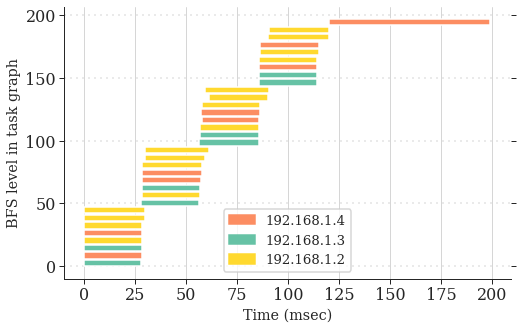

In [448]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import os
import json
import itertools
import matplotlib
import matplotlib.ticker as ticker

def format_xticks(x, pos=None):
    return str(int(x*1000))

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Time (msec)')

sns.despine()
ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))

#ax.set_yticks([5, 15, 27, 32, 40])
#ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_ylabel('BFS level in task graph')


# Setting graph attribute
ax.grid(True)

workers_color = {'192.168.1.4': '#fc8d62',
               '192.168.1.3': '#66c2a5', 
                '192.168.1.2': '#ffd92f' }
with open(gfile, 'r') as fd:
    data = ast.literal_eval(fd.read())
    base = 0
    size = 5
    margin = 1
    for ts in data['tasks']:
        #print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
        if ts['worker'] not in workers_load:
            workers_load[ts['worker']] = []
        #workers_load[ts['worker']].append((ts['start_ts'], ts['end_ts'] - ts['start_ts']))
        ax.broken_barh([(ts['start_ts'], ts['end_ts'] - ts['start_ts'])], (base, size), 
                       facecolors =(workers_color[ts['worker']]))
        base += (size + margin)
ax.legend(['192.168.1.4', '192.168.1.3', '192.168.1.2'], loc=8)
ax.get_legend().legendHandles[0].set_color('#fc8d62')
ax.get_legend().legendHandles[1].set_color('#66c2a5')
ax.get_legend().legendHandles[2].set_color('#ffd92f')

1023


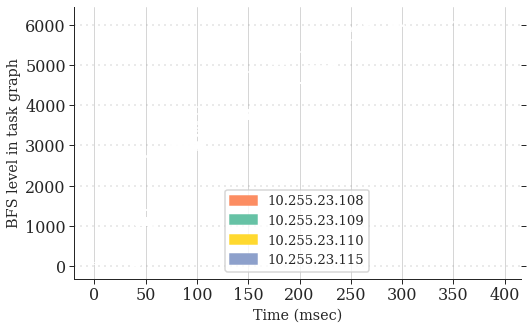

In [511]:
    
def format_xticks(x, pos=None):
    return str(int(x*1000))

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Time (msec)')

sns.despine()
ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))

#ax.set_yticks([5, 15, 27, 32, 40])
#ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_ylabel('BFS level in task graph')


# Setting graph attribute
ax.grid(True)

workers_color = {'10.255.23.108': '#fc8d62',
                 '10.255.23.109': '#66c2a5', 
                 '10.255.23.110': '#ffd92f',
                 '10.255.23.115': '#8da0cb'}



base = 0
size = 5
margin = 1
for ts in tasks:
    #print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
    if ts['worker'] not in workers_load:
        workers_load[ts['worker']] = []
    ax.broken_barh([(ts['start_ts'], ts['end_ts'] - ts['start_ts'])], (base, size), 
                   facecolors =(workers_color[ts['worker']]))
    base += (size + margin)
    
ax.legend(list(workers_color.keys()), loc=8)
ax.get_legend().legendHandles[0].set_color('#fc8d62')
ax.get_legend().legendHandles[1].set_color('#66c2a5')
ax.get_legend().legendHandles[2].set_color('#ffd92f')
ax.get_legend().legendHandles[3].set_color('#8da0cb')

In [542]:
jfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.json'


tasks = []
with open(jfile, 'r') as fd:
    stats = ast.literal_eval(fd.read())
    task_time = []
    for s in stats:
        task_style[s]['output_size'] = stats[s]['msg']['nbytes']
        startsstops = stats[s]['msg']['startstops']
        for ss in startsstops:
            if ss['action'] == 'compute': 
                #print(s, ss['stop'] - ss['start'], task_style[s]['output_size'])
                task_time.append(ss['stop'] - ss['start'])
import numpy as np
arr = np.array(task_time)

# measures of central tendency
mean = np.mean(arr)
median = np.median(arr)
  
# measures of dispersion
_min = np.amin(arr)
_max = np.amax(arr)
range = np.ptp(arr)
varience = np.var(arr)
sd = np.std(arr)
  
print("Descriptive analysis")
print("Array =", arr)
print("Measures of Central Tendency")
print("Mean =", mean)
print("Median =", median)
print("Measures of Dispersion")
print("Minimum =", _min)
print("Maximum =", _max)
print("Range =", range)
print("Varience =", varience)
print("Standard Deviation =", sd)

Descriptive analysis
Array = [6.93798065e-05 2.28881836e-05 3.99398804e-03 ... 4.76837158e-05
 3.91006470e-05 4.48226929e-05]
Measures of Central Tendency
Mean = 0.002175582585563175
Median = 8.344650268554688e-06
Measures of Dispersion
Minimum = 3.0994415283203125e-06
Maximum = 0.053134918212890625
Range = 0.053131818771362305
Varience = 3.946271315805763e-05
Standard Deviation = 0.0062819354627421655


In [480]:
jfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.json'


tasks = []
workers = {}
with open(jfile, 'r') as fd:
    stats = ast.literal_eval(fd.read())
    
    min_ts = sys.maxsize
    print(len(stats))
    for s in stats:
        task_style[s]['output_size'] = stats[s]['msg']['nbytes']
        startsstops = stats[s]['msg']['startstops']
        print(s, stats[s]['worker'])
        for ss in startsstops:
            if ss['action'] == 'inputsize': continue
            if ss['start'] < min_ts:  min_ts = ss['start']
            if ss['stop'] < min_ts:  min_ts = ss['stop']
        
        ws = stats[s]['worker']
        if ws not in workers:
            workers[ws] = 0
        workers[ws] += 1    
        #break
            
            
    for s in stats:
        task_style[s]['output_size'] = stats[s]['msg']['nbytes']
        startsstops = stats[s]['msg']['startstops']
        min_start = sys.maxsize
        max_end = 0
        
        for ss in startsstops:
            if ss['action'] == 'inputsize': continue
            if ss['start'] < min_start:  min_start = ss['start']
            if ss['stop'] > max_end:  max_end = ss['stop']
        
        tasks.append({'name': s, 'start_ts': min_start - min_ts, 'end_ts': max_end - min_ts, 
                      'worker': stats[s]['worker'].split(':')[1].replace('/', ''),
                     'short_name': s.split('-')[0].replace("('", )})
        #break
    

768
('random_sample-3589e62988427c0de37f225ba9ed313c', 0, 14) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 14, 11) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 8, 1) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 8, 0) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 14, 1) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 13, 13) tcp://10.255.23.109:34511
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 4, 11) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 14, 0) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 10, 10) tcp://10.255.23.110:43021
('random_sample-3589e62988427c0de37f225ba9ed313c', 0, 8) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 10, 0) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 14, 12) tcp://10.255.

In [512]:
df = pd.DataFrame(tasks)
df['runtime'] = df['end_ts'] - df['start_ts']
df

,name,start_ts,end_ts,worker,runtime
0,add-934864d6-8a87-49b5-a815-cec7a2ed843c,0.037606,0.037675,10.255.23.115,0.000069
1,add-d5b2db9e-8cce-4c90-8cb9-2968749f3eff,0.037783,0.037806,10.255.23.115,0.000023
2,add-deb5f76e-6077-4824-826c-efb36ec2cb8f,0.037874,0.041868,10.255.23.115,0.003994
3,add-2beb9684-9a07-4afd-8133-2158d85d84fa,0.037920,0.044914,10.255.23.115,0.006994
4,add-edd09d53-329f-4685-8e0e-52e40bdc20bb,0.038078,0.045166,10.255.23.115,0.007089
...,...,...,...,...,...
1018,add-33ec713e-483f-4375-aba3-4a6e02c56da7,0.345843,0.345854,10.255.23.110,0.000010
1019,add-99545666-fbac-4b2a-9873-84ee97ede34c,0.338607,0.343286,10.255.23.108,0.004679
1020,add-9f5f3fc3-5fa4-4d82-9b48-1824cd758b66,0.376662,0.380290,10.255.23.115,0.003628
1021,add-107ef289-6c26-45d0-b05f-588d7b236d14,0.386185,0.388679,10.255.23.115,0.002493


In [ ]:
df['start_ts'].min(), df['start_ts'].max()

{'tcp://10.255.23.110:43021': 213,
 'tcp://10.255.23.109:34511': 197,
 'tcp://10.255.23.115:35597': 178,
 'tcp://10.255.23.108:35669': 180}